# BRIC algorithm applied to artificial data

<br>
This notebook presents the application of the BRIC algorithm to artificial distributions, as complementary material of the article 

To run this notebook interactively, follow the link below:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/adrienbrilhault/BRIC/HEAD?filepath=demo_ArtificialData.ipynb)


## Requirements

The following R packages are required for the execution of the notebook:

* [ggplot2](https://ggplot2.tidyverse.org/) (install using the command `install.package("ggplot2")`)
* [mvtnorm](https://cran.r-project.org/package=mvtnorm) (install using the command `install.package("mvtnorm")`)
* [BRIL](https://github.com/adrienbrilhault/BRIL) (first install the package [remotes](https://github.com/r-lib/remotes) if missing: `install.package("remotes")`, then the BRIC package with `remotes::install_github("adrienbrilhault/BRIC", subdir = "pkg")`)

Once installed, load the libraries.


In [1]:
# load libraries
suppressPackageStartupMessages(library(BRIC))
suppressPackageStartupMessages(library(mvtnorm))
suppressPackageStartupMessages(library(ggplot2))

## Generate an artificial distribution

Draw a compound distribution of bivariate normals and uniform noise based on the parameters below:


In [2]:
set.seed(123)

# number of uniform samples
sizeNoise <- 150

# size of each cluster
clusters <- list()
clusters$size <- c(300, 150, 200)

# variance of each cluster
clusters$variance <- runif(length(clusters$size), min = 1, max = 5)

# range of coordinates
plotArea <- matrix(c(0, 50, 0, 40), 2, 2)

Generate the mixtures and plot:


Main cluster center coordinates: ( 13 , 36 )

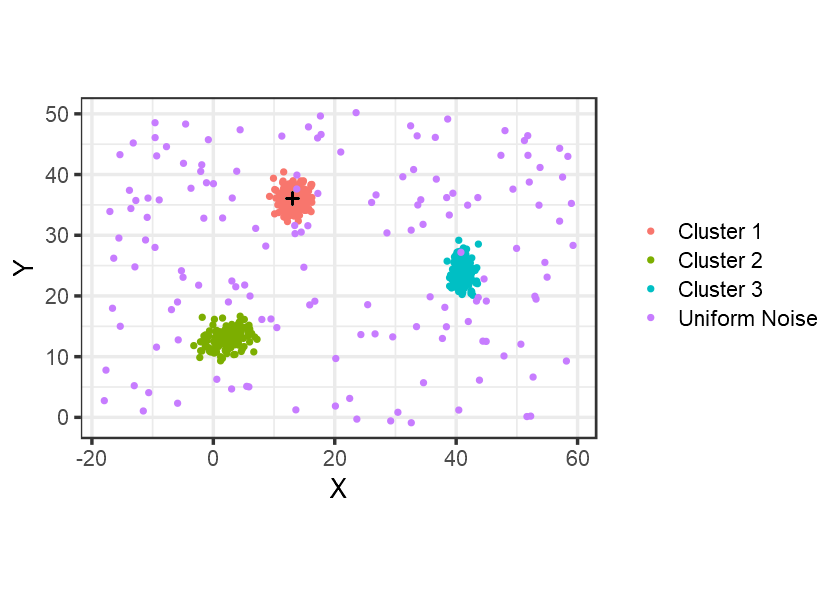

In [3]:
#  Draw random coordinates for each cluster, sufficiently far from each other to avoid overlap
clusters$positions <- matrix(rep(0, len = length(clusters$size) * 2), ncol = 2)
if (length(clusters$size) > 1) {
  while (min(dist(clusters$positions)) < max(clusters$variance * 3 * 2)) {
    clusters$positions <- matrix(c(sample(plotArea[1, 1]:plotArea[2, 1],
      length(clusters$size),
      replace = T
    ), sample(plotArea[1, 2]:plotArea[2, 2], length(clusters$size), replace = T)), ncol = 2)
  }
}

# Draw multivariate normals
samples <- data.frame()
for (i in 1:length(clusters$size)) {
  sigma <- matrix(c(1 / runif(1, min = 1, max = 4), 0, 0, 1), nc = 2) *
    clusters$variance[i]
  theta <- runif(1, min = 0, max = 2 * pi)
  rot <- matrix(c(cos(theta), sin(theta), -sin(theta), cos(theta)), nrow = 2)
  sigma <- rot %*% sigma %*% t(rot)
  bivnorm <- mvtnorm::rmvnorm(clusters$size[i], clusters$position[i, ], sigma)
  samplesTmp <- data.frame(X = bivnorm[, 1], Y = bivnorm[, 2], category = paste("Cluster", i))
  samples <- rbind(samples, samplesTmp)
}

# Draw uniform noise
areaNoise <- matrix(c(
  range(samples$X) + c(-1, +1) * diff(range(samples$X)) / 3,
  range(samples$Y) + c(-1, +1) * diff(range(samples$Y)) / 3
), 2)
noiseSamples <- data.frame(
  X = runif(sizeNoise, areaNoise[1, 1], areaNoise[2, 1]),
  Y = runif(sizeNoise, areaNoise[1, 2], areaNoise[2, 2]), category = "Uniform Noise"
)

# Final distribution
samples <- rbind(samples, noiseSamples)

# Plot
theme_set(theme_bw(base_size = 16))
options(repr.plot.width = 7, repr.plot.height = 5)
g <- ggplot(samples, aes(X, Y, color = category)) +
  geom_point(size = 1) +
  theme(legend.title = element_blank()) +
  coord_fixed()
g <- g + geom_point(aes(
  x = clusters$positions[1, 1],
  y = clusters$positions[1, 2]
), colour = "black", shape = 3, size = 2)
print(g)

cat("Main cluster center coordinates: (", clusters$positions[1, 1],
     ",", clusters$positions[1, 2], ")")

## BRIC - Bootstrap
_Compute a first estimate of central tendency through recursive trimming of low-depth samples._

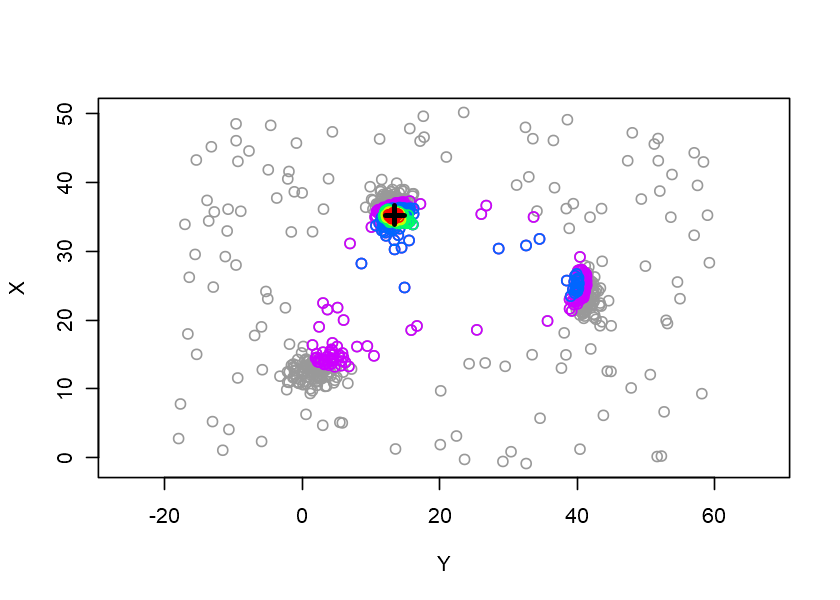

In [4]:
firstEstimate <- median_rec(samples[, 1:2], method = "Spatial", alpha = 0.5)

options(repr.plot.width = 7, repr.plot.height = 5)
plot(firstEstimate, asp = 1, nbIterations = 5, showMedian = TRUE)

## BRIC - Refine

_Improve the precision of the estimate by two filtering processes, the first based on euclidean distances and a test of unimodality. The second on robust distances and a test of multivariate normality._

#### Filtering 1- Unimodal Filtering

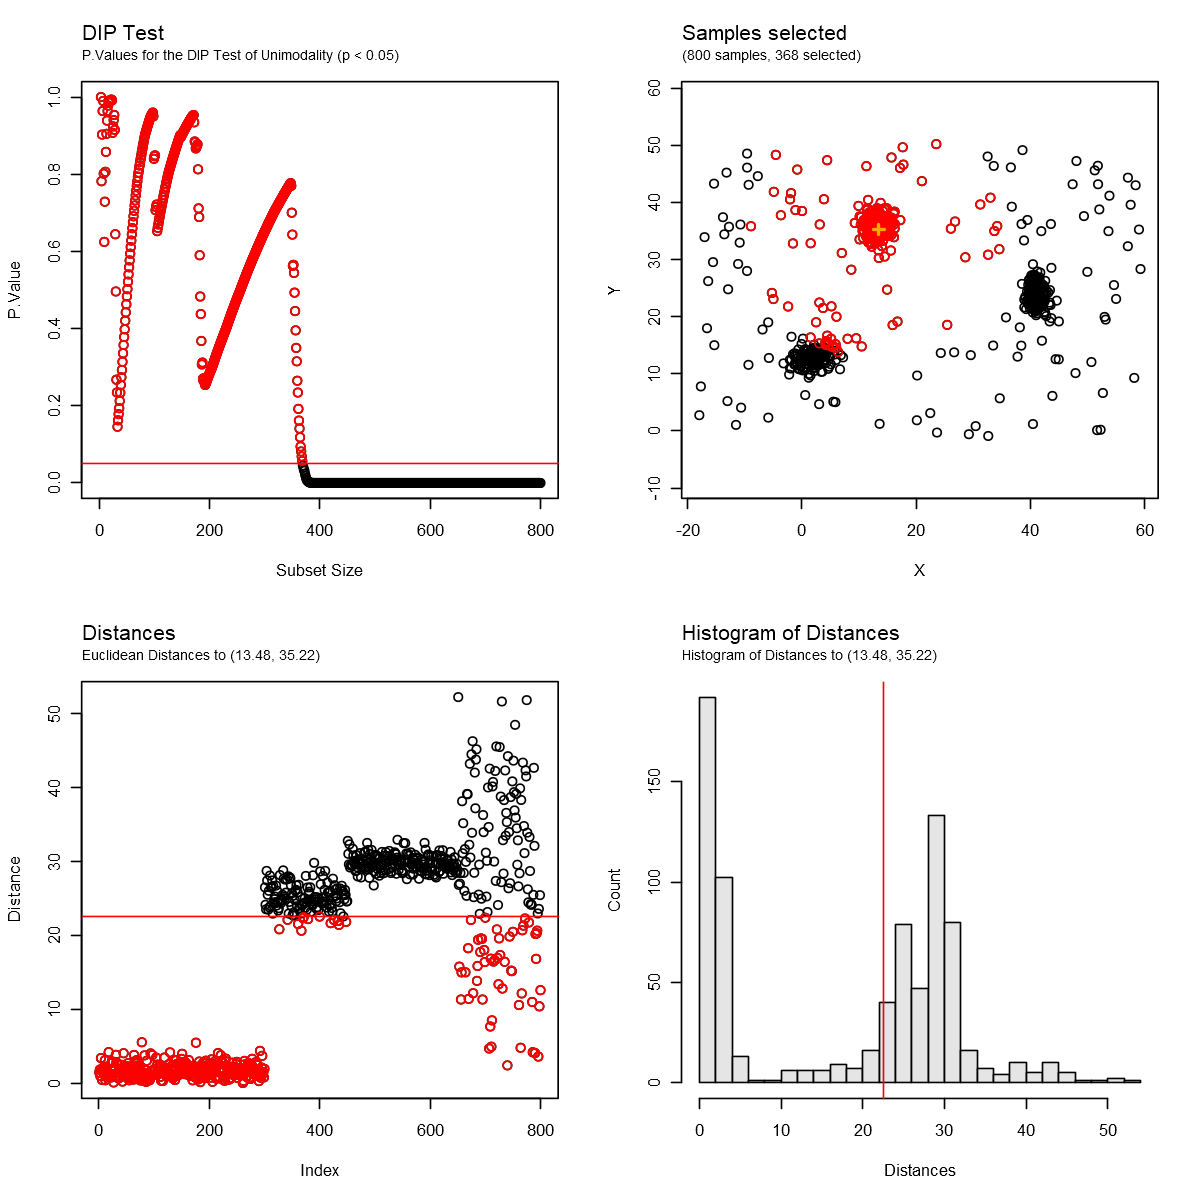

In [5]:
filt_unimodal <- filter_outliers(samples[, 1:2],
    center = firstEstimate$median,
    test = "DIP", threshold = 0.05, debug = TRUE
)

options(repr.plot.width = 10, repr.plot.height = 10)
plot(filt_unimodal, asp = 1)

#### Filtering 2- Normal Filtering

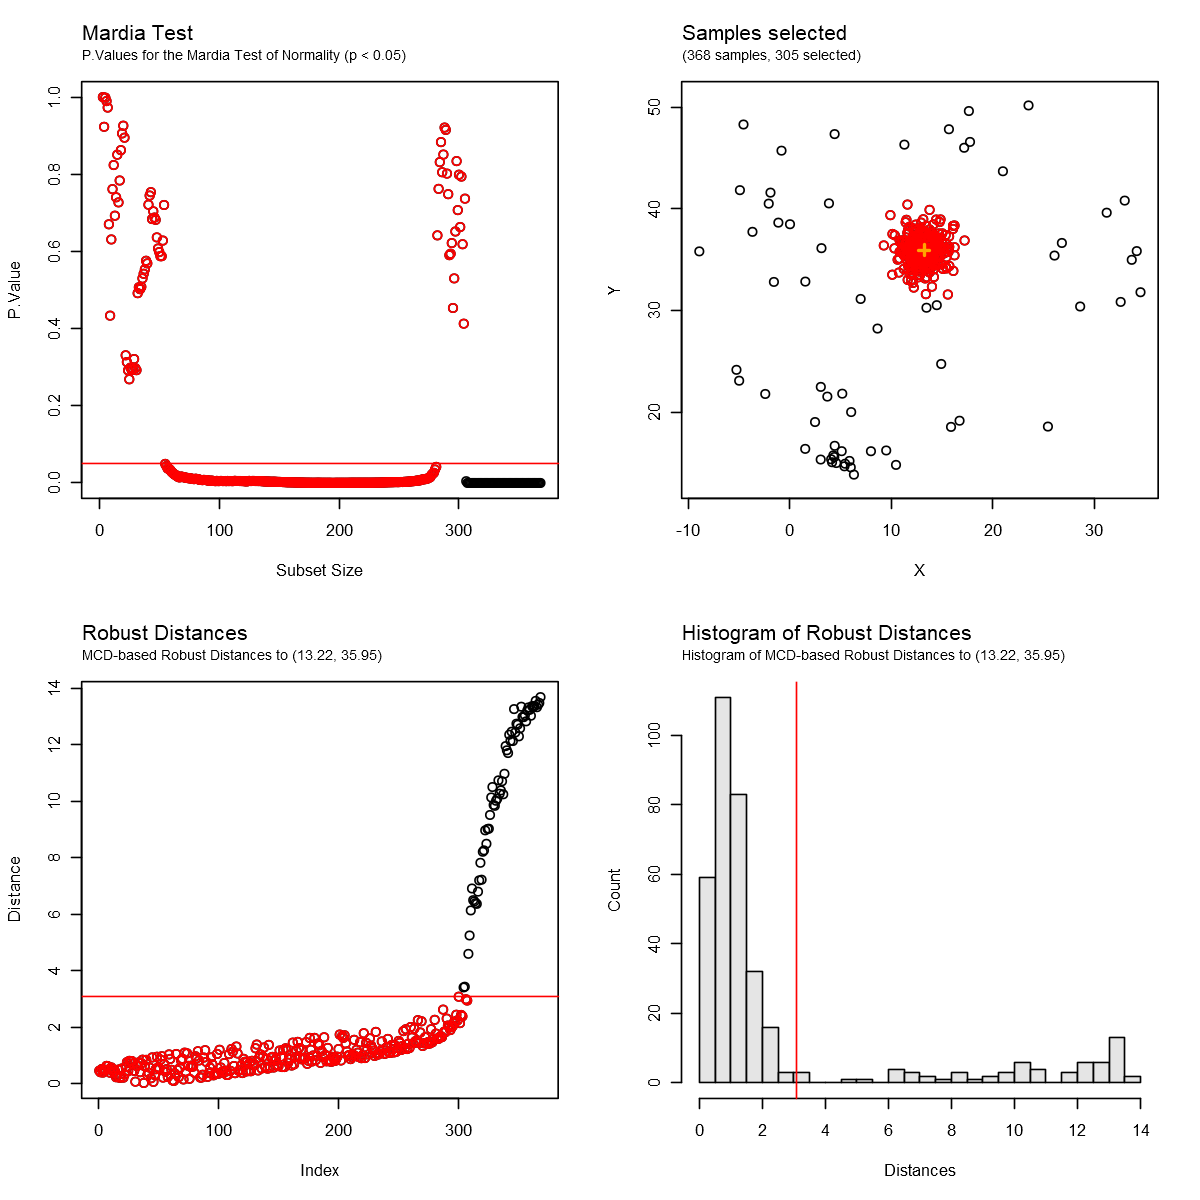

In [6]:
# Correct the estimate within this subset for a more accurate ordering in the second step
correctedEstimate <- median_rec(samples[filt_unimodal$selected, 1:2],
    method = "Spatial", alpha = 0.5
)

# Filter furthest outliers based on robust distances until reaching a normal-like subset
filt_normal <- filter_outliers(samples[filt_unimodal$selected, 1:2],
    center = correctedEstimate$median, test = "Mardia", threshold = 0.05, debug = TRUE
)

plot(filt_normal, asp = 1)

In [7]:
firstEstimate$median

X        Y 
13.48031 35.22051

In [8]:
correctedEstimate$median

X        Y 
13.22288 35.94772

In [9]:
refinedEstimate <- colMeans(filt_normal$call$data[filt_normal$selected, ])
refinedEstimate

X        Y 
13.15157 35.90861

## BRIC - Iterate
_Remove the final subset selected at the end of REFINE from the global distribution, and re-iterate the same procedure to identity other groups that might have a higher cardinality._

In [10]:
res <- clustBRIC(samples[, 1:2],
    method = "Spatial", testUnimodal = "DIP", threshUnimodal = 0.05,
    testNormal = "Mardia", threshNormal = 0.05, debug = TRUE
)

xlim <- c(min(samples[, 1]), max(samples[, 1]))
ylim <- c(min(samples[, 2]), max(samples[, 2]))

#### Iteration 1 - Unimodal Filtering

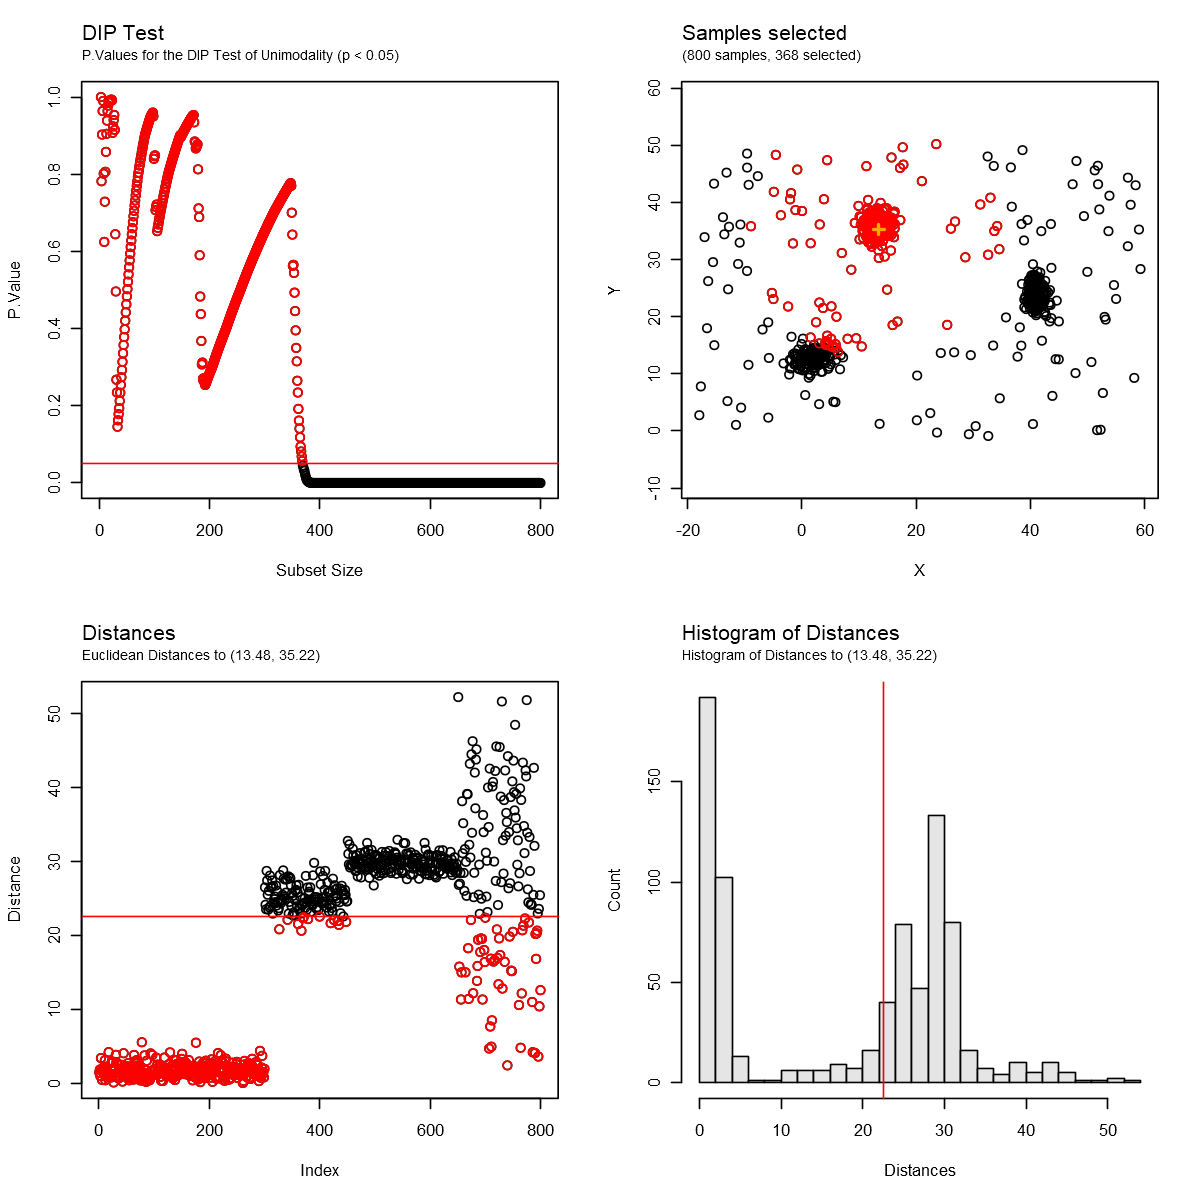

In [11]:
plot(res$iterations[[1]]$filteringUnimodal, asp = 1, xlim = xlim, ylim = ylim)

#### Iteration 1 - Normal Filtering

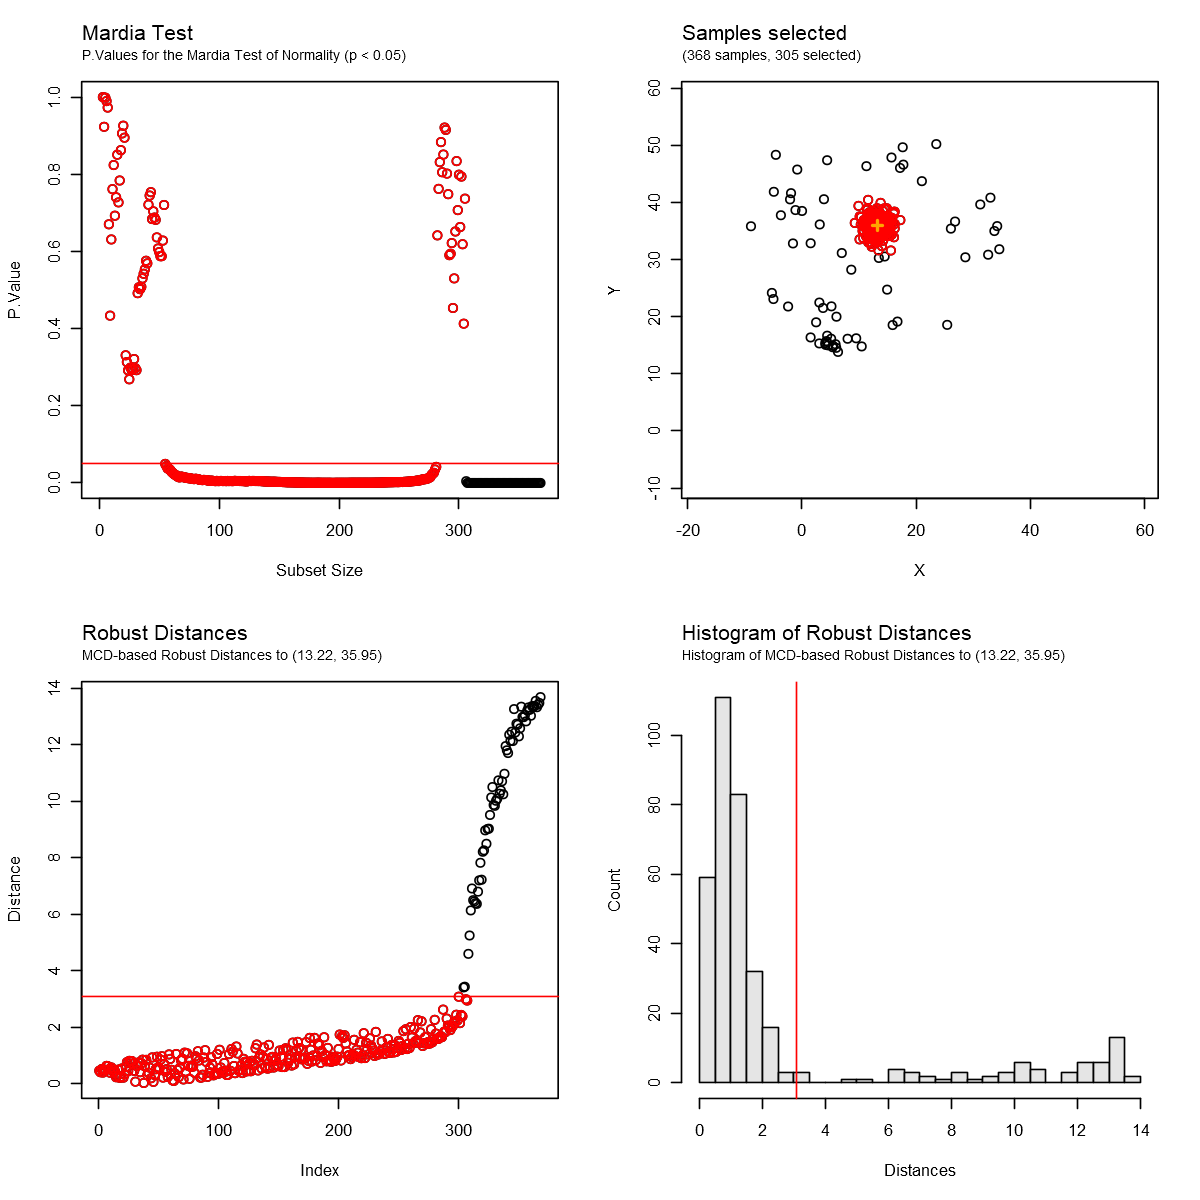

In [12]:
plot(res$iterations[[1]]$filteringNormal, asp = 1, xlim = xlim, ylim = ylim)

#### Iteration 2 - Unimodal Filtering

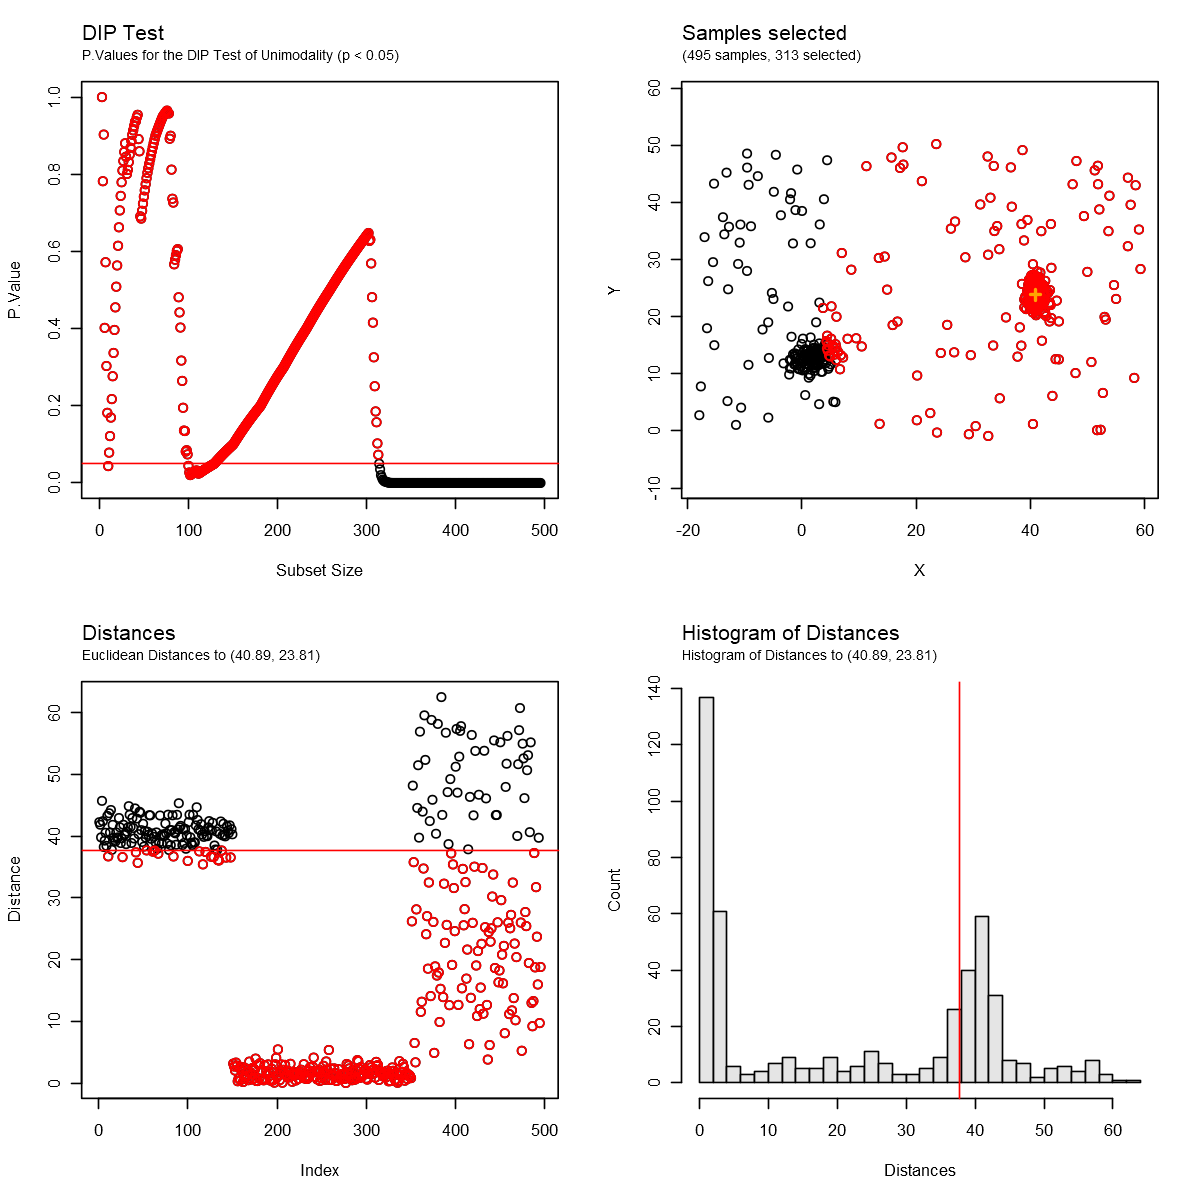

In [13]:
if (res$nbClusters >= 2)
      plot(res$iterations[[2]]$filteringUnimodal, asp = 1, xlim = xlim, ylim = ylim)

#### Iteration 2 - Normal Filtering

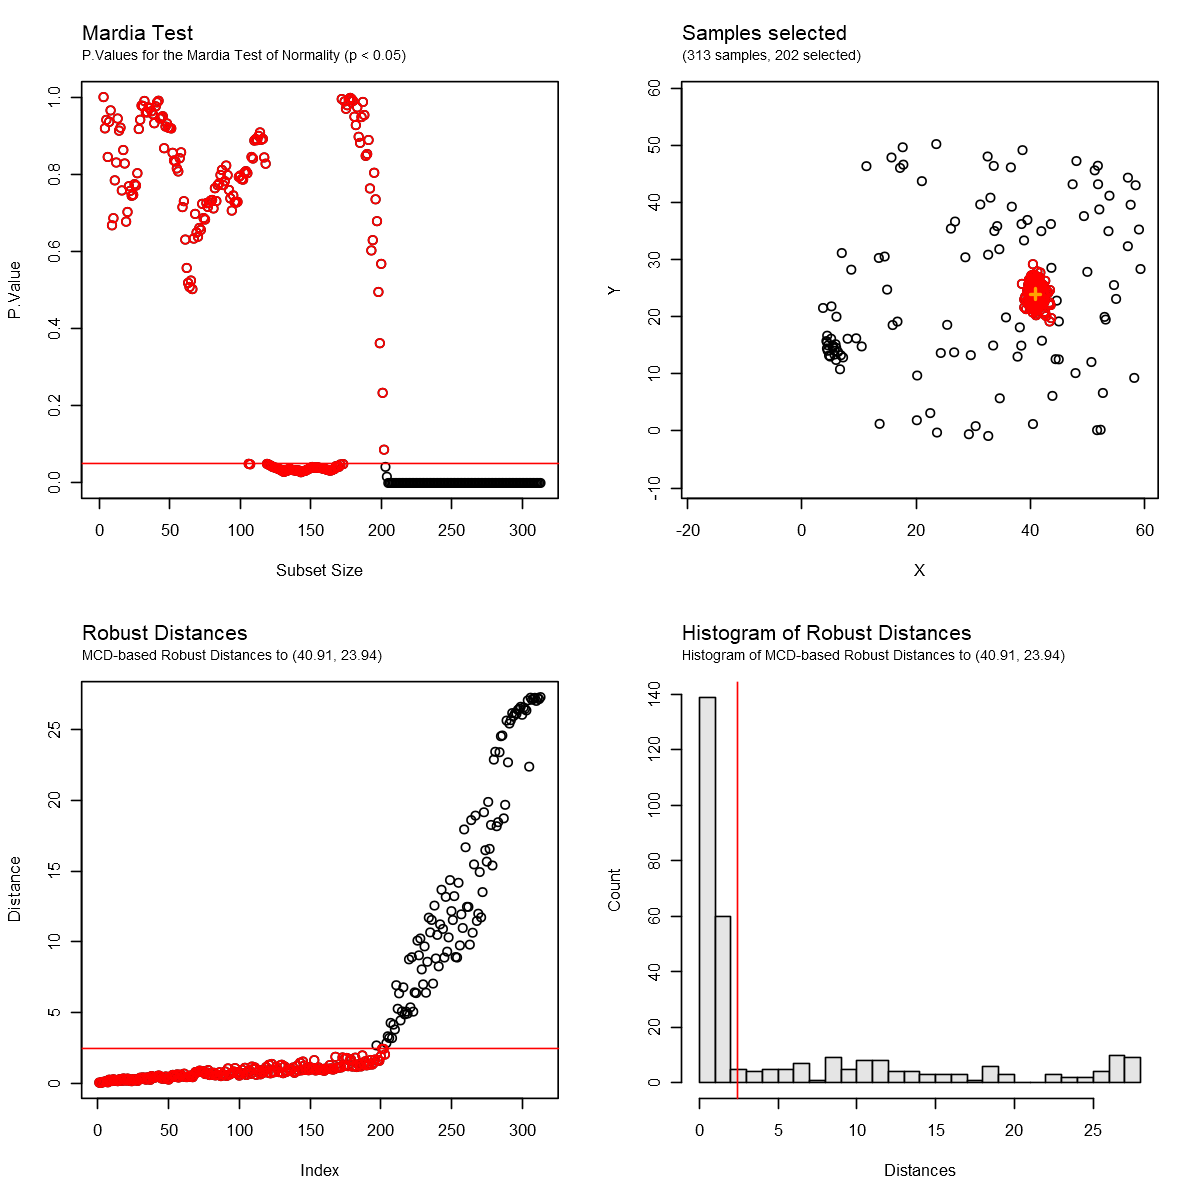

In [14]:
if (res$nbClusters >= 2)
      plot(res$iterations[[2]]$filteringNormal, asp = 1, xlim = xlim, ylim = ylim)

#### Iteration 3 - Unimodal Filtering

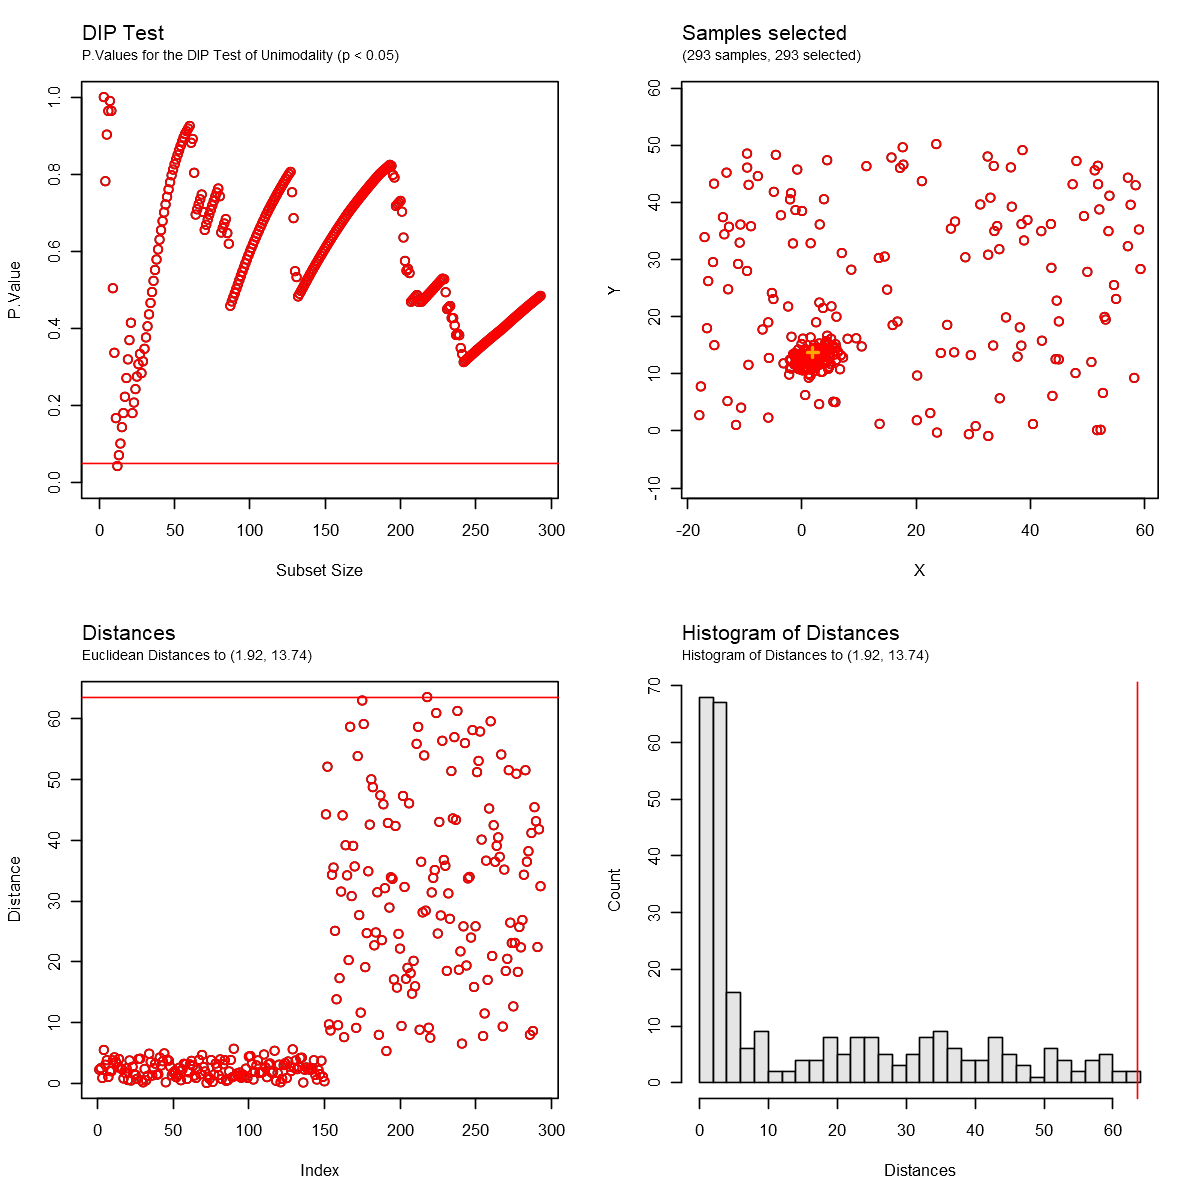

In [15]:
if (res$nbClusters >= 3)
      plot(res$iterations[[3]]$filteringUnimodal, asp = 1, xlim = xlim, ylim = ylim)

#### Iteration 3 - Normal Filtering

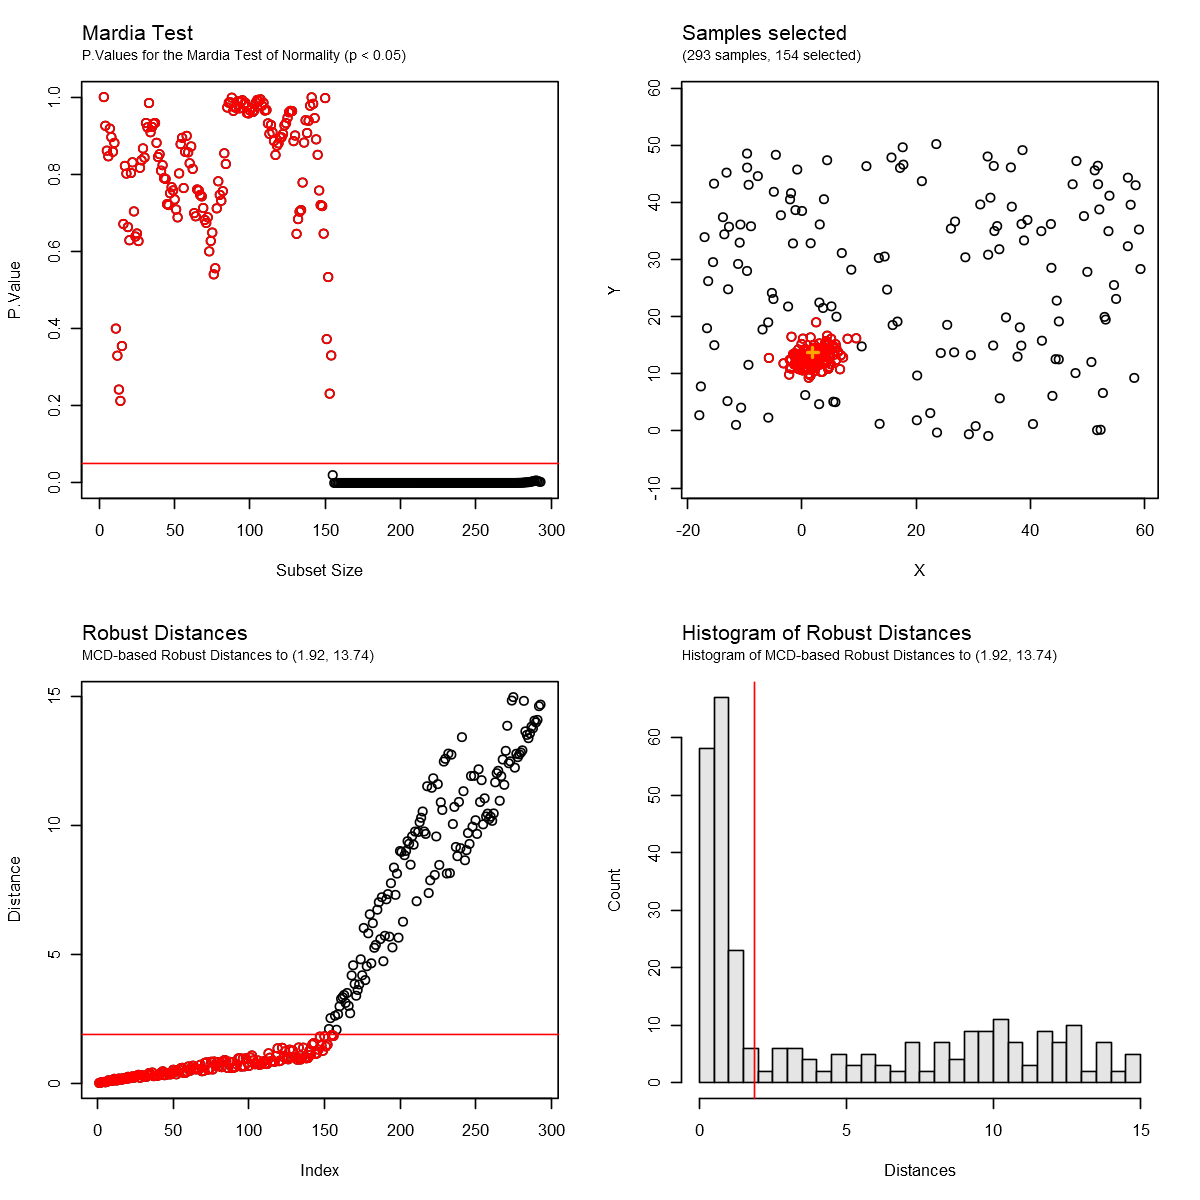

In [16]:
if (res$nbClusters >= 3)
      plot(res$iterations[[3]]$filteringNormal, asp = 1, xlim = xlim, ylim = ylim)

<br>**_... until starting an iteration with a distribution being unimodal before any outliers filtering, which will terminate the search._**

## Final result of the algorithm

In [17]:
res


=> Results for clustBRIC() using method "Spatial" (alpha=0.5), DIP Unimodality Test (> 0.05), and Mardia Normality test (> 0.05)
   800 samples: 3 clusters identified (sizes 305, 202, 154), and 139 samples unassigned

Clusters Sizes:
[1] 305 202 154


Clusters Centers:
             X        Y
[1,] 13.151573 35.90861
[2,] 41.033893 23.93398
[3,]  2.127943 13.10919


Labels:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[260] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

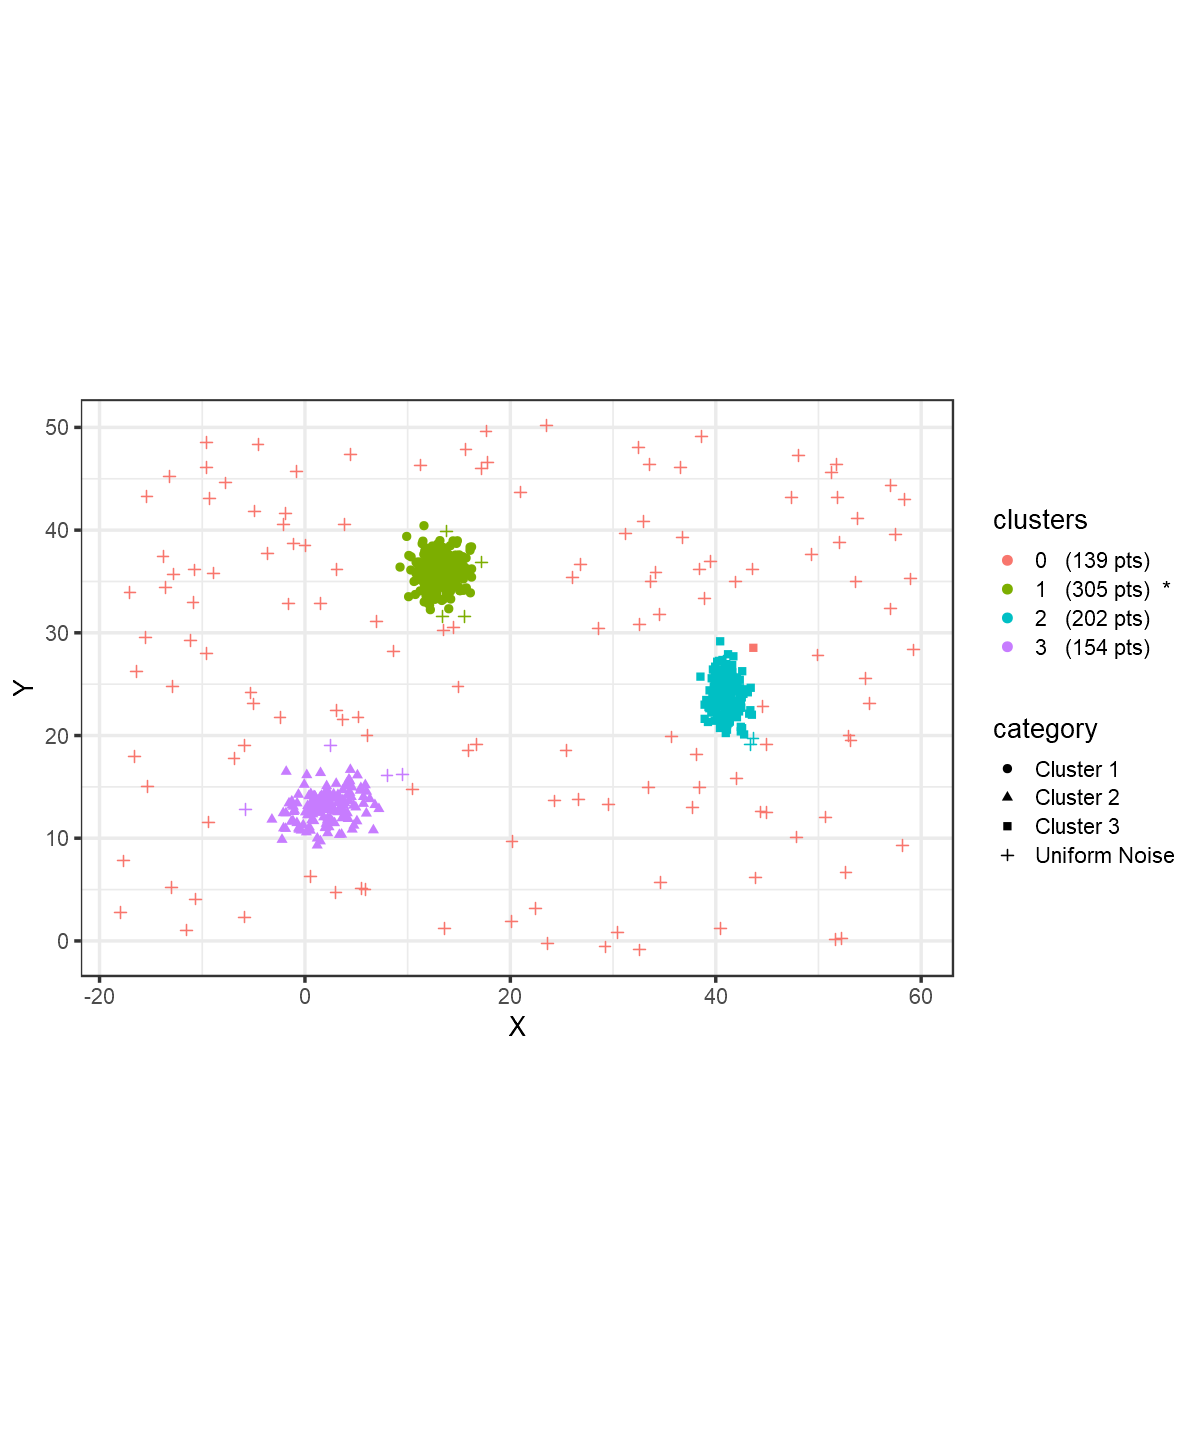

In [18]:
# plot the final result with the main mode

samples$labels <- factor(res$labels)
labelsCluster <- c()
for (i in sort.int(unique(res$labels))) {
  labelsCluster[[as.character(i)]] <- sprintf("%d   (%d pts)", i, length(which(res$labels == i)))
}
labelsCluster[[as.character(res$mainCluster)]] <- paste(labelsCluster[[as.character(res$mainCluster)]], " *")

options(repr.plot.width = 10, repr.plot.height = 12)
ggplot(samples, aes(X, Y, color = labels, group = labels, shape = category)) +
  geom_point(size = 2) +
  scale_color_discrete(labels = labelsCluster, name = "clusters") +
  coord_fixed(ratio = 1, expand = TRUE)